In [2]:
import pickle
import torch
import torch_geometric as tg

import networkx as nx

import pandas as pd
import numpy as np

In [3]:
with open(r'inf_scores.pkl', 'rb') as f:
    x = pickle.load(f)[0]

print(x.keys())

dict_keys(['influence_score', 'xpos', 'edges'])


In [69]:
df = pd.DataFrame(x['influence_score'])

In [70]:
df.max()

0        9.303403
1        3.590150
2      102.492393
3       62.869156
4       93.204910
          ...    
426      0.550917
427      7.510477
428      0.913677
429      6.399168
430      1.485898
Length: 431, dtype: float32

In [27]:
df.index.name = 'source' # TODO is this right?

melted = df.melt(ignore_index = False)
melted = melted.reset_index() # Move source index to be a column, gives unique index
melted = melted.rename(columns={'variable': 'target',
                                'value': 'influence_score',
                                'index': 'source'})

In [28]:
source_coords = pd.DataFrame(x['xpos'])
target_coords = source_coords.copy()

source_coords.index.name = 'source'
source_coords = source_coords.reset_index()

target_coords.index.name = 'target'
target_coords = target_coords.reset_index()


target_cords = target_coords.rename(columns={0: 'target_x', 1: 'target_y'})
source_coords = source_coords.rename(columns={0: 'source_x', 1: 'source_y'})

In [29]:
print(len(melted))

185761


In [30]:
melted = melted.merge(source_coords, on='source', how='left')
melted = melted.merge(target_cords, on='target', how='left')

In [31]:
print(len(melted))

185761


In [32]:
melted['distance_sq'] = (melted['source_x'] - melted['target_x'])**2 + (melted['source_y'] -
                                                                        melted['target_y'] )**2
melted['distance'] = np.sqrt(melted['distance_sq'])

In [33]:
print(len(melted))

185761


<Axes: xlabel='distance', ylabel='influence_score'>

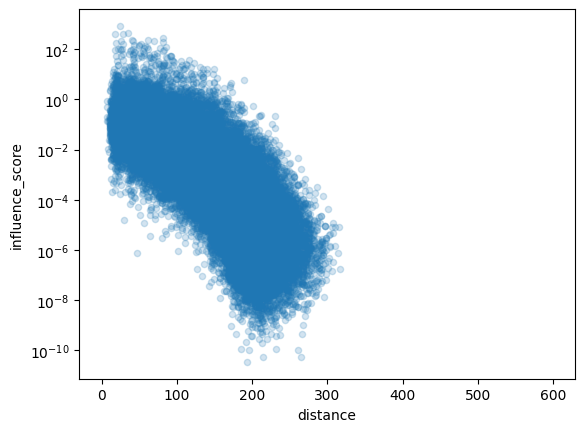

In [45]:
melted.plot.scatter('distance', 'influence_score', logy=True, alpha=0.2,)

### Graph Based Distance Measure

In [64]:
edges = x['edges'].copy().astype(int)

coords = x['xpos'].copy()

edges = torch.Tensor(edges)
coords = torch.Tensor(coords)

data = tg.data.Data(edge_index=edges,
                    x=coords)

In [66]:
g = tg.utils.convert.to_networkx(data)

In [87]:
shortest_paths = nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(g, weight=None)
shortest_paths = pd.DataFrame(shortest_paths)

shortest_paths_map = shortest_paths.melt(ignore_index=False)
shortest_paths_map = shortest_paths_map.reset_index()
shortest_paths_map = shortest_paths_map.rename(columns={'index': 'source',
                                                        'variable': 'target',
                                                        'value': 'graph_distance'}
                                               )

shortest_paths_map['graph_distance'] = shortest_paths_map['graph_distance'].astype('int')

KeyError: 'graph_distance'

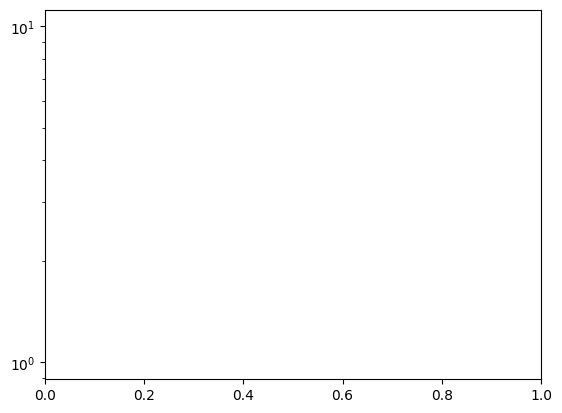

In [91]:
melted = melted.merge(shortest_paths_map, on=['source', 'target'])
melted.plot.scatter('graph_distance', 'influence_score', logy=True, alpha=0.2,)